# Вариант 9

Рассматривается система линейных гиперболических уравнений:

\begin{gather*}
    \frac { \partial \mathbf { u } } { \partial t } + \mathbf { A } \frac { \partial \mathbf { u } } { \partial x } = \mathbf { b } ( x ) , ~ 0 \leqslant x \leqslant 1, ~ 0 \leqslant t \leqslant 1, ~~ 
    \mathbf { u } ( x , 0 ) = \left( \begin{array} { c } { 2 x - x ^ { 3 } } \\ { x ^ { 3 } } \\ { x ^ { 2 } + 1 } \end{array} \right) \\
    \mathbf { A } = \left( \begin{array} { c c c } { - 21 / 2 } & { 27 / 2 } & { 3 / 2 } \\ { - 7 } & { 9 } & { 1 } \\ { 13 / 2 } & { - 19 / 2 } & { - 3 / 2 } \end{array} \right), ~~ 
    \mathbf { b } ( x ) = \left( \begin{array} { l } { 0 } \\ { 0 } \\ { 0 } \end{array} \right)
\end{gather*}

Привести систему к характеристическому виду, предложить корректную постановку граничных условий.

Решить численно систему уравенний с использованием двух указанных схем.
Для каждой из схем выписать первое дифференциальное приближение (ПДП), 
определить, диссипативная или дисперсионная ошибка преобладает.
Монотонна ли схема? Оценить апостериорно порядок сходимости каждой схемы.

### Разностные схемы
Схемы приводятся для модельного уравнения $ \frac { \partial u } { \partial t } + a \frac { \partial u } { \partial x } = 0 , ~ a = \text { const } > 0 $ на сетке $ x _ { m } = m h , ~ m = 0 \dots M , ~ M h = 1 ; ~ t ^ { n } = n \tau , ~ n = 0 \dots N, ~ N \tau = 1 $. При необходимости преобразовать схемы для случая $ a = \text{const} < 0 $.

1) "Неявный" правый уголок (схема бегущего счета)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n + 1 } - u _ { m } ^ { n + 1 } } { h } = 0
\end{equation}

2) Центральная схема второго порядка (Лакса-Вендроффа, МакКормака)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } } { 2 h } = \frac { a ^ { 2 } \tau } { 2 } \frac { u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } } { h ^ { 2 } }
\end{equation}

## Анализ системы

Приведем систему к характеристическому виду. Для этого найдем левые собственные вектора (см. код ниже), затем приведем систему к каноническому виду. Это реализовано ниже.

In [1]:
# Подготовительный этап
from IPython.display import display, Math, Latex, Markdown
import pprint
import sympy as sp
from sympy import Matrix, Rational, latex, symbols
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
from matplotlib import animation
x, u, t = sp.symbols('x u t')

In [2]:
# Вбиваем данные задачи
A = Matrix([
    [Rational(-21, 2), Rational(27, 2), Rational(3, 2)], 
    [-7, 9, 1], 
    [Rational(13, 2), Rational(-19, 2), Rational(-3, 2)]
])
#A = sp.diag(10, 5, 30)
b = Matrix([0, 0, 0])
u = Matrix([2*x - x**3, x**3, x**2 + 1])

In [3]:
# Ищем собственные вектора и собственные значения
print('Собственные значения и собственные вектора:')
tmp = A.T.eigenvects()
# Выводим это на экран
for i, tup in enumerate(tmp):
    display(Math(
        '\lambda_{0} = {1}; ~ \omega_{0} = {2}'
        .format( str(i+1), tup[0], latex(tup[2][0]) )
    ))

Собственные значения и собственные вектора:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# Считаем матрицы, которые нам потом пригодятся
Omega = Matrix([Matrix(i[2][0]).T for i in tmp])
lambdas = [i[0] for i in tmp]
Lambda = sp.diag(*lambdas)

In [5]:
display(Latex(r'Запишем матрицу перехода: $ \Omega = {}$'.format(latex(Omega))),
        Latex(r'а также обратную ей: $ \Omega^{{-1}} = {}$'.format(latex(Omega**(-1)))),
        Math(r'A = \Omega^{-1} \Lambda \Omega')
       )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [6]:
u

Matrix([
[-x**3 + 2*x],
[       x**3],
[   x**2 + 1]])

In [7]:
I = Omega*u
display(
    Math(r'\mathbf{{I}} (x, 0) = {}, ~~~~ \Lambda = {}'
         .format( latex(I), latex(Lambda) )
        )
)

<IPython.core.display.Math object>

#### О постановке граничных условий:
В нашей системе есть 0 положительных собственных значений, 1 нулевое и 2 
отрицательных. 
Значит, на левой границе не нужно ставить граничных условий, на правой же границе нужно 2.
В нулевом значении достаточно задать только начальное условие.

Попробуем поставить граничные условия вида:

\begin{equation}
u|_{t = 0} = f(x), ~~ u|_{x = 1} = g(t)
\end{equation} 

На них будет наложено необходимое условие разрешимости:
$ f(1) = g(0) $.
Потребуем также, чтобы производная не терпела разрыв: $ f'(1) = g'(0) $. Итого:

\begin{gather}
    \boxed{
    f(1) = g(0) \\
    f'(1) = g'(0)
    }
\end{gather}

In [8]:
x_nepr_border = [I[i].subs(x, x-lambdas[i]*t).subs(x, 1) for i in range(len(lambdas))]
exact_sol = [I[i].subs(x, x-lambdas[i]*t) for i in range(len(lambdas))]
exact_sol_funcs = [sp.lambdify((t, x), exact_sol[i]) for i in range(len(lambdas))]
display(
    Markdown('Итак, мы получили {} уравнения:'.format(Lambda.shape[0])),
    *[
        Math( 
            (r'\cfrac{{\partial I_{i} }} {{\partial t}} {sign}{koeff}\cdot'+ 
             r'\cfrac{{\partial I_{i} }} {{\partial x}} = {left_part}' +
             ', ~ I_{i} (x, 0) =' 
            ).format(
                i=(k+1), 
                sign='+' if lambdas[k] >= 0 else '-',
                koeff=abs(lambdas[k]),
                size=Lambda.shape[0],
                left_part=b[k]
            )
            + sp.latex( (Omega*u)[k] )
        ) for k in range(Lambda.shape[0])
    ],
    Markdown(
        'Эти уравнения имеют решения:',
    ),
    *[Math( 
        'I_{} (t, x) = '.format(i+1) + 
        latex(exact_sol[i]) 
    ) for i in range(len(lambdas))],
    Markdown(
        'из которых (полагая, что решение должно быть из класса $C^1$) имеем граничные условия:'
    ),
    *[
        Math(
            r'\left. I_{n} \right|_{{x={x_max}}} (t) = '.format(n=i+1, x_max=1) +
            latex(x_nepr_border[i])
        ) for i in range(len(lambdas))
    ]
)

Итак, мы получили 3 уравнения:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Эти уравнения имеют решения:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

из которых (полагая, что решение должно быть из класса $C^1$) имеем граничные условия:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
from utils import make_grid, AnimationHelper

In [10]:
X_MIN, X_MAX, T_MIN, T_MAX = 0.0, 1.0, 0.0, 1.0

In [11]:
# pure function
def calculate_all(kernel, timezero_funcs, xzero_funcs,
                  a, h, tau, 
                  x_min=0, x_max=1, t_min=0, t_max=1, fictive_x=True):
    """
    Делает подсчеты с заданным ядром метода для всех компонент
    """
    tmp = []
    # Создаем сетку
    T, x_grid, t_grid = make_grid(x_min, x_max, t_min, 
                                   t_max, h, tau, fictive_x=fictive_x)
    # Для каждой компоненты
    for i in range(len(timezero_funcs)):
        # Считаем значения
        func_t, func_x, a_curr = timezero_funcs[i], xzero_funcs[i], np.float64(a[i])
        # Начальные условия
        T[:,0] = func_t(x_grid)
        # Граничные условия
        T[-1,:] = func_x(t_grid)
        # Приводим все к double
        T = T.astype('double')
        # Высчитываем sigma
        sigma = np.double(a_curr*tau/h)
        # Вызываем калькулятор
        kernel_results = kernel(T, sigma)
        if fictive_x:
            kernel_results = kernel_results[1:-1, :]
        tmp.append(kernel_results.T)
    if fictive_x:
        x_grid = x_grid[1:-1]
    return tmp, x_grid, t_grid

In [12]:
def plot_3d(x_grid, t_grid, u_i, position, label='u_1', filename='no_name'):
    from mpl_toolkits import mplot3d
    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection='3d')
    xx, yy = np.meshgrid(x_grid, t_grid)
    ax.plot_surface(xx, yy, u_i.T)
    ax.view_init(*position)
    ax.set_title(r'$ {} $'.format(label))
    ax.set_xlabel(r'$ x $')
    ax.set_ylabel(r'$ t $')
    fig.savefig(filename)
    fig.show()

## Решение схемой неявного правого уголка
Данная схема преобразуется к виду:

\begin{equation}
    u_m^{n+1} (1 - \sigma) + \sigma u_{m+1}^{n+1} = u_m^n, ~~ \sigma = \frac{a \tau}{h}
\end{equation}

Будем искать решение в виде: 
\begin{gather*}
u_m^n = \exp \left(\lambda (k) t_n + ikx_m \right) = \exp (\lambda n \tau + ikmh), ~~ \lambda (k) = -ika \\
\cfrac{1}{\tau} (e^{\lambda \tau} - 1) + \cfrac{a}{h} \left(e^{\lambda \tau} e^{i k h}-e^{\lambda \tau}\right)=0 \\
e^{\lambda \tau}\left(1-a \cfrac{\tau}{h}(\cos k h+i \sin k h-1)\right)=1
\end{gather*}

Получаем дисперсиооное уравнение:
\begin{equation}
    \lambda(\tau, h, k)=\frac{1}{\tau} \ln \left(\frac{1}{1-\sigma(\cos kh+i \sin kh - 1)}\right), ~~ \sigma=a \frac{\tau}{h}
\end{equation}

При $k h \ll 1$ дисперсионное соотношение вплоть до членов второго порядка будет:
\begin{equation*}
    \lambda(\tau, h, k)=-i k a-\frac{a}{2 h}(\sigma+1)(k h)^{2}
\end{equation*}

Тогда частное решение примет вид:
\begin{equation*}
    \exp (i k(m h-a n \tau)) \cdot \exp \left(-a k^{2} \frac{h}{2}(\sigma+1) n \tau\right)
\end{equation*}
где первый множитель совпадает с
соответствующим частным решением дифференциального уравнения. Второй
множитель имеет чисто разностное происхождение.

При любых $\sigma$ второй множитель затухает с ростом $t_n$ тем быстрее, чем больше $k$.
Таким образом, численное решение, полученное по данной схеме, отличается от
точного, в котором все гармоники сохраняют амплитуду с ростом $t_n$, наличием
затухающего множителя для гармоник с большими волновыми числами. Действие
этого множителя приводит к сглаживанию решений, имеющих разрыв в начальных
данных. В данном случае _преобладает диссипативная ошибка_.


### ПДП
Запишем схему в виде
\begin{equation}
    \frac{\hat{u}_{m}-u_{m}}{t}+a \frac{\hat{u}_{m+1}-\hat{u}_{m}}{h}=0
\end{equation}
где "крышки" отвечают шагу $n+1$ по времени, а без "крышек" - шагу $n$. Разложим функции:
\begin{equation*}
    \hat{u}_{m}=u_{m}+\tau u_{t}+\frac{1}{2} \tau^2 u_{t t}
\end{equation*}
\begin{equation*}
    \hat{u}_{m+1}=\hat{u}_{m}+h \hat{u}_{x}+\frac{1}{2} h^{2} \hat{u}_{x x} = u_{m}+\tau u_{t}+\frac{1}{2} \tau^{2} u_{t t} + h \left(u_{m}+\tau u_{t}+\frac{1}{2} \tau^{2} u_{t t}\right)_{x} + 
\end{equation*}

\begin{equation*}
    + \frac{1}{2} h^{2}\left(u_{m}+\tau u_{t}+\frac{1}{2} \tau^{2} u_{tt}\right)_{xx} \approx u_{m}+\tau u_{t}+\frac{1}{2} \tau^{2} u_{t t}+h u_{x} + \tau h u_{x t} + \frac{1}{2} h^{2} u_{x x}
\end{equation*}
\begin{equation*}
u_{t}=-a u_{x} \Rightarrow u_{t x}=-a u_{x x}=u_{x t} \Rightarrow \hat{u}_{m+1}=u_{m}+\tau u_{t}+\frac{1}{2} \tau^{2} u_{tt} + h u_x - \tau h a u_{xx} + \frac{1}{2} h^2 u_{xx}
\end{equation*}
\begin{equation*}
u_{tt} = a^2 u_{xx} 
\end{equation*}
\begin{equation*}
\psi_{m}=\left(u_{t}+a u_{x}\right)_{m}-\left[\frac{1}{\tau}\left(\hat{u}_{m}-u_{m}\right)+\frac{a}{h}\left(\hat{u}_{m+1}-\hat{u}_{m}\right)\right] = \dots
\end{equation*}
\begin{equation*}
= 2 a u_{x}+u_{xx}\left(-\frac{1}{2} \tau a^{2}+\frac{1}{2} h a\right)
\end{equation*}

**ПДП**: $\boxed{u_t = a u_x + u_{xx} \cdot \cfrac{ha}{2} (-3\sigma + 1)}$

Для расчета значения слева воспользуемся схемой "прямоугольник", имеющей порядок аппроксимации $O(\tau^2 + h^2)$:
\begin{gather*}
    \frac{u_{m-1}^{p+1}-u_{m-1}^{p}+u_{m}^{p+1}-u_{m}^{p}}{2 \tau}+\frac{u_{m}^{p+1}-u_{m-1}^{p+1}+u_{m}^{p}-u_{m-1}^{p}}{2 h}=0 \\
    12
\end{gather*}

In [13]:
from numba import jit
    
@jit(nopython=True)
def ugolok_kernel(T, sigma):
    """
    Предполагается, что граничные условия УЖЕ заданы
    """
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        # Решим систему и запишем результаты в следующую итерацию времени
        for m in range(M-2, 0, -1):
            T[m, n+1] = 1/(1-sigma)*T[m,n] - sigma/(1-sigma)*T[m+1,n+1]
        # Последнее значение пересчитаем по схеме "прямоугольник"
        T[0, n+1] = 1/(1-sigma)*(T[0, n] - T[1, n+1] + T[1, n]) + sigma/(1-sigma)*(T[0, n] - T[1, n+1] - T[1, n])
    return T

In [14]:
h, tau = 10**-3, 10**-3/4

In [15]:
timezero_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
# Наглядные синусы
#'''
xzero_funcs = [
    lambda t: np.sin(10*t)+timezero_funcs[0](1),
    lambda t: np.sin(10*t)+timezero_funcs[1](1),
    lambda t: np.sin(10*t)+timezero_funcs[2](1)
]
#'''
# Не очень наглядно: просто константа
'''
xzero_funcs = [
    lambda t: timezero_funcs[0](1),
    lambda t: timezero_funcs[1](1),
    lambda t: timezero_funcs[2](1),
]
'''
# Продолжение по непрерывности. С ним и будем сравнивать
#xzero_funcs = [sp.lambdify(t, x_f) for x_f in x_nepr_border]
#xzero_funcs = [sp.lambdify(t, func1.subs(x, X_MAX)) for func1 in exact_sol]

'\nxzero_funcs = [\n    lambda t: timezero_funcs[0](1),\n    lambda t: timezero_funcs[1](1),\n    lambda t: timezero_funcs[2](1),\n]\n'

In [16]:
tmp = calculate_all(ugolok_kernel, timezero_funcs, xzero_funcs, 
                    lambdas, h, tau, 
                    x_min=X_MIN, x_max=X_MAX, t_min=T_MIN, t_max=T_MAX)
T, x_grid, t_grid = np.array(tmp[0]), tmp[1], tmp[2]
del tmp

In [17]:
# Вернемся обратно от инвариантов Римана
omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)
del omega_rev

In [18]:
u_1_ugol = solution[:,:,0]
u_2_ugol = solution[:,:,1]
u_3_ugol = solution[:,:,2]

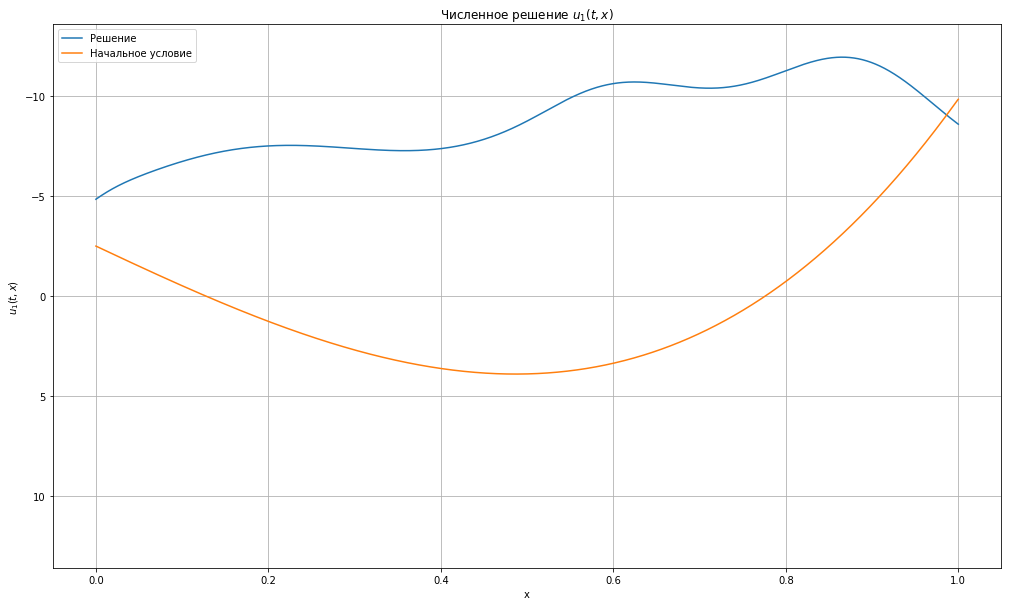

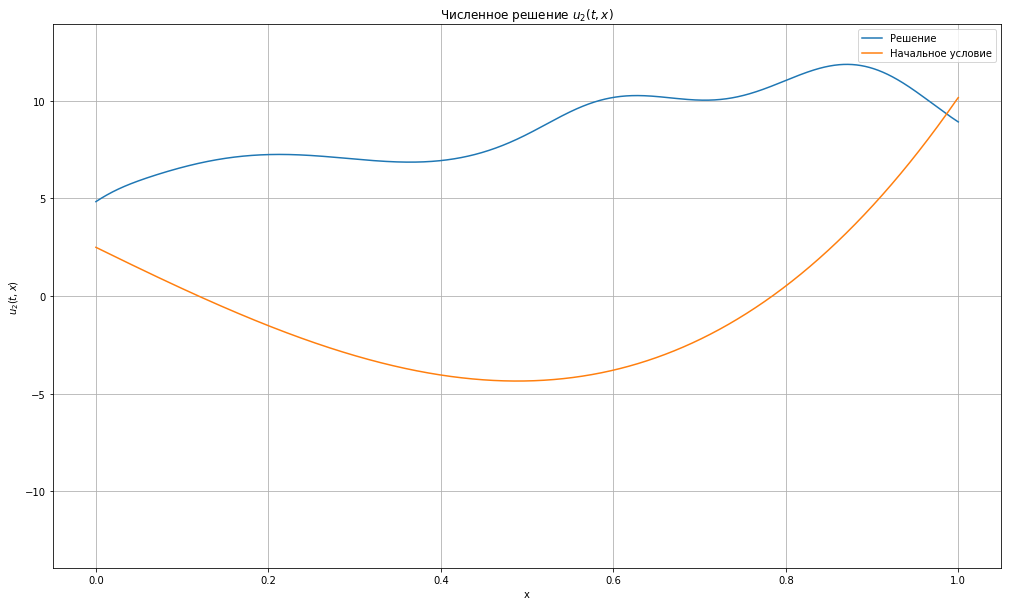

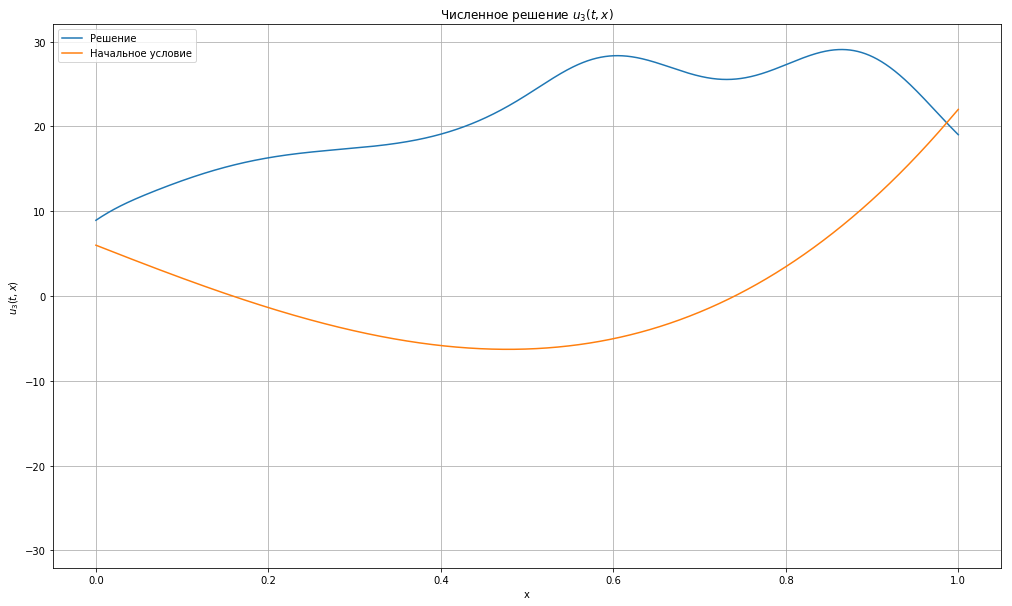

In [19]:
# Анимация первой координаты
anim1 = AnimationHelper(u_1_ugol, x_grid=x_grid, t_grid=t_grid, ylabel='u_1')
anim1.make_animation().save_as_file('ugolok_u1.mp4')

# Анимация второй координаты
anim2 = AnimationHelper(u_2_ugol, x_grid=x_grid, t_grid=t_grid, ylabel='u_2')
anim2.make_animation().save_as_file('ugolok_u2.mp4')

# Анимация третьей координаты
anim3 = AnimationHelper(u_3_ugol, x_grid=x_grid, t_grid=t_grid, ylabel='u_3')
anim3.make_animation().save_as_file('ugolok_u3.mp4')

Для наглядности построим график еще 3D график 

C:\Users\aleks\Miniconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


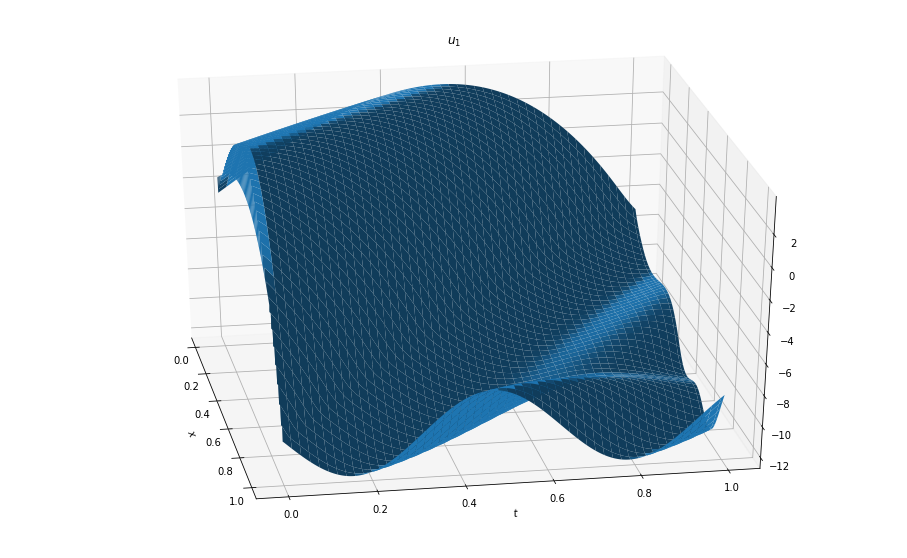

In [20]:
plot_3d(x_grid, t_grid, solution[:,:,0], (30, -10), label='u_1', filename='ugol_u1.pdf')

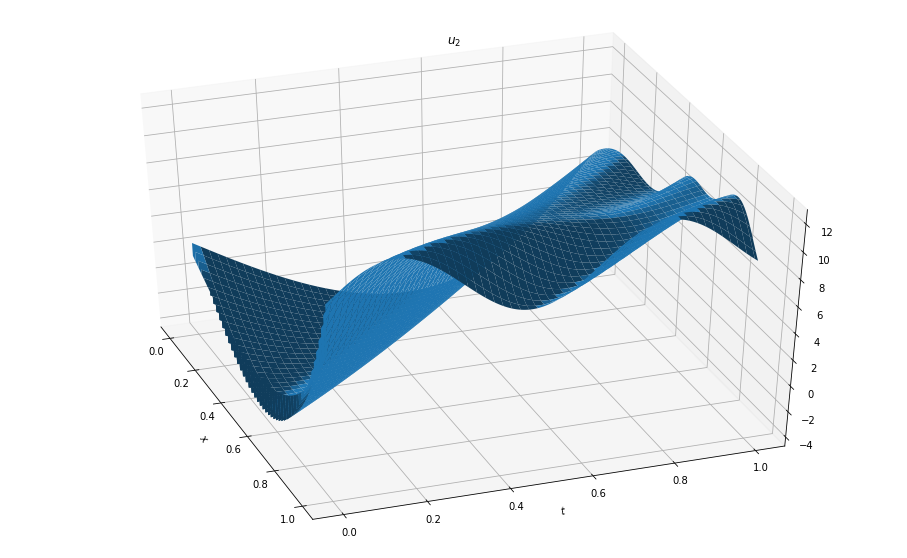

In [21]:
plot_3d(x_grid, t_grid, solution[:,:,1], (40, -20), label='u_2', filename='ugol_u2.pdf')

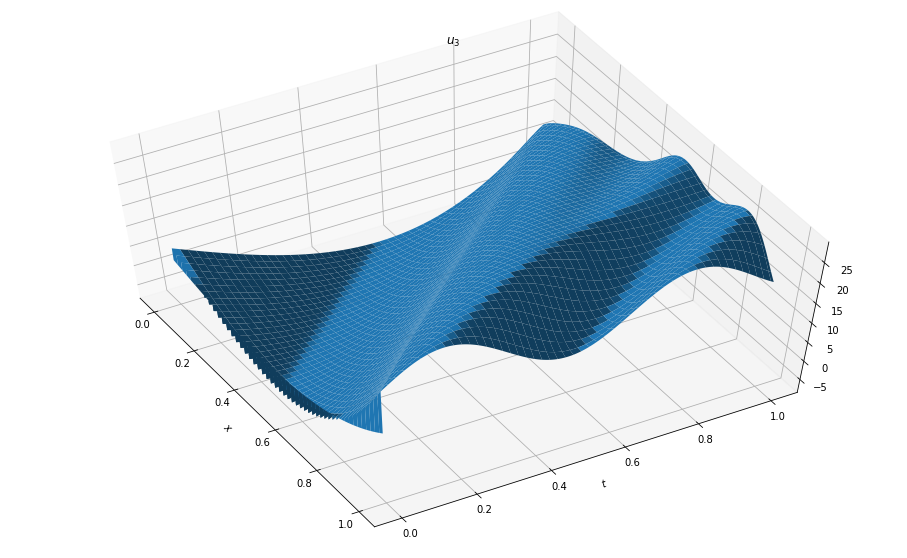

In [22]:
plot_3d(x_grid, t_grid, solution[:,:,2], (60, -30), label='u_3', filename='ugol_u3.pdf')

Для определения порядка аппроксимации воспользуемся теми граничными условиями, которые определяют функцию из класса $C^1$. Они были выписаны выше, при теоретическом анализе схемы.

Мы будем считать ошибку по инвариантам Римана (как разность теоретического решения и численного).

In [23]:
timezero_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
# Наглядные синусы
'''
xzero_funcs = [
    lambda t: np.sin(10*t)+timezero_funcs[0](1),
    lambda t: np.sin(10*t)+timezero_funcs[1](1),
    lambda t: np.sin(10*t)+timezero_funcs[2](1)
]
'''
# Не очень наглядно: просто константа
'''
xzero_funcs = [
    lambda t: timezero_funcs[0](1),
    lambda t: timezero_funcs[1](1),
    lambda t: timezero_funcs[2](1),
]
'''
# Продолжение по непрерывности. С ним и будем сравнивать
#xzero_funcs = [sp.lambdify(t, x_f) for x_f in x_nepr_border]
xzero_funcs = [sp.lambdify(t, func1.subs(x, X_MAX)) for func1 in exact_sol]

In [24]:
@jit(parallel=True)
def count_errors(exact_sol_func, kernel, 
                         tau, a,
                         h_range, sigma=0.5, 
                         x_min=0, x_max=1, t_min=0, t_max=1):
    sigma = 0.5
    tmp = []
    for h in h_range:
        # Пересчитаем tau через sigma
        # sigma = np.double(a_curr*tau/h)
        tau = sigma*h/abs(a)
        print('tau =', tau)
        # Создаем сетку для каждого h
        T, x_grid, t_grid = make_grid(x_min, x_max, t_min, 
                                   t_max, h, tau, fictive_x=True)
        print('Created T...')
        # Создаем сетку для подсчета точного решения
        tt, xx = np.meshgrid(t_grid, x_grid)
        exact = exact_sol_func(tt, xx)
        print('Calculated EXACT...')
        # Граничные условия СПРАВА!!!
        # А вот начальные условия -- на t_min
        func_t, func_x = lambda t: exact_sol_func(t, x_max), lambda x: exact_sol_func(t_min, x)
        # Начальные условия
        T[:,0] = func_t(x_grid)
        # Граничные условия
        T[-1,:] = func_x(t_grid)
        print('Calculated inital values...')
        # Приводим все к double
        #T = T.astype('double')
        approx = kernel(T, sigma).T
        print('Calculated approx solution...')
        tmp.append(approx - exact.T)
    return tmp

In [25]:
tau = 10**(-2)/2

In [26]:
# Все будем судить по 1-ой координате
N_coord = 0
h_range = np.linspace(10**(-2), 10**(-1), 30)
different_calcs = count_errors(jit(exact_sol_funcs[N_coord]), ugolok_kernel,
                                       tau, lambdas[N_coord],
                                       h_range,
                                       sigma=0.5)

tau = 0.00250000000000000
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00327586206896552
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00405172413793103
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00482758620689655
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00560344827586207
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00637931034482759
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00715517241379310
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00793103448275862
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00870689655172414
Created T...
Calculated EXACT...
Calcu

In [27]:
errors = np.array([np.linalg.norm(different_calcs[i].astype('float')) for i in range(len(different_calcs))])

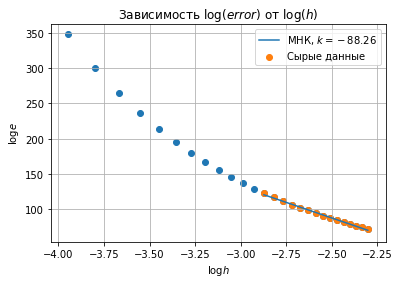

In [28]:
y_plot = np.log(errors)
x_plot = np.log(h_range)

plt.scatter(x_plot, y_plot)
N_forfit_left, N_forfit_right = int(len(x_plot)*0.5), int(len(x_plot)*1)
x_forfit, y_forfit = x_plot[N_forfit_left:N_forfit_right], y_plot[N_forfit_left:N_forfit_right]
plt.scatter(x_forfit, y_forfit, label=r'Сырые данные')

# Нанесем прямую МНК
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x_forfit, y_forfit)
x_plot_forfit = np.linspace(min(x_forfit), max(x_forfit), 10**3)
y_plot_forfit = slope*x_plot_forfit + intercept
plt.plot(x_plot_forfit, y_plot_forfit, label='МНК, $k={}$'.format(slope.round(2)))

plt.grid()
plt.legend()
plt.xlabel(r'$\log h$')
plt.ylabel(r'$\log e$')
plt.title(r'Зависимость $\log(error)$ от $\log(h)$')
plt.savefig('errors_ugolok.pdf')
plt.show()

Желтыми обозначены точки, по которым строится линейная регрессия.

In [29]:
display(
    Markdown(
        'Апостериорный порядок сходмиости $k={}$ (коэфф. корреляции $r={}$)'.format(
            abs(slope.round(2)), abs(r_value.round(4))
        )
    )
)

Апостериорный порядок сходмиости $k=88.26$ (коэфф. корреляции $r=0.9973$)

Это значение порядка сходимости странное. Объяснение этому следующее: поскольку я брал граничные условия как продолжение по непрерывности решения уравенения, это привело (из-за того, что начальное условие - парабола) к росту значений _y_ и, следовательно, росту и накоплению ошибки вычислений по схеме. На графике это отражено в виде чисел порядка $10^{300}$ (см. левые точки).

## Решение центральной схемой второго порядка

Данная схема преобразуется к виду:
\begin{equation*}
    u _ { n } ^ { n + 1 } = u _ { m } ^ { n } - \frac { a \tau } { 2 h } \left( u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } \right) + \frac { a ^ { 2 } \tau ^ { 2 } } { 2 h ^ { 2 } } \left( u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } \right)
\end{equation*}
Мы введем два фиктивных узла по сетке $x$ (слева и справа). На каждой итерации по $n$ (время) значения в фиктивных узлах будем пересчитывать через линейную интерполяцию по двум предыдущим точкам (поскольку $h$ мало, это должно хватить).

### Первое дифференциальное приближение
Перепишем схему в виде:

\begin{gather*}
    \cfrac{u_{m+1}^{n+1} - u_m^n}{\tau} + a \cfrac{u_{m+1}^n - u_{m-1}^n}{2h} - \cfrac{a^2 \tau}{2} \cfrac{u_{m+1}^n - 2 u_m^n + u_{m-1}^n}{h^2} = 0 \\
    u_m^{n+1} = u_m^n + \tau u_t + \cfrac{1}{2} \tau^2 u_{tt} + \cfrac{1}{6} \tau^3 u_{ttt} \\
    u_{m-1}^n = u_m^n - h u_x + \cfrac{1}{2} h^2 u_{xx} - \cfrac{1}{6} h^3 u_{xxx} \\
    u_{m+1}^n = u_m^n + h u_x + \cfrac{1}{2} h^2 u_{xx} + \cfrac{1}{6} h^3 u_{xxx} \\
\end{gather*}
Невязка равна: $ \psi_n = (u_t + a u_x)_n - \left[ \cfrac{1}{\tau} ( u_m^{n+1} u_m^n) + \cfrac{a}{2h} (u_{m+1}^n - u_{m-1}^n) - \cfrac{a^2 \tau}{2h^2} (u_{m+1}^{n} - 2 u_{m}^{n} + u_{m-1}^{n}) \right] $

$ \phi_{n} = -\cfrac{\tau}{2} u_{tt} + \cfrac{a^2 \tau}{2} u_{xx} - \cfrac{\tau^2}{6} u_{ttt} - \cfrac{ah^2}{6} u_{xxx} $
С учетом того, что $ u_{tt}a^2 = u_{xx} $ и $ u_{ttt} = -a^3 u_{xxx} $ , имеем $ \psi_{n} = \cfrac{a}{6} (\tau^2 a^2 - h^2 ) u_{xxx} $.

**ПДП**:  $ \boxed{u_{t} = \cfrac{a}{6} (\tau^2 a^2 -h^2) u_{xxx} - a u_{x} }$ .

Для заданной схемы дисперсионное соотношение имеет вид:

\begin{equation}
    \lambda=\frac{1}{\tau} \ln \left(1-i \sigma \sin k h-2 \sigma^{2} \sin ^{2} \frac{k h}{2}\right)
\end{equation}
для длинноволновых гармоник с $ kh \ll 1 $ разложение вплоть до членов третьего порядка по этой величине дает

\begin{equation}
    \lambda(\tau, h, k) \approx-i k a+i k a \frac{k^{2} h^{2}}{6}\left(1-3 \sigma^{2}\right).
\end{equation}

Из полученных соотношений делаем вывод, что решения разностного уравнения второго порядка аппроксимации имеют вид:

$ y\left(t_{n}, x_{m}\right)=\exp \left(i k x_{m}+\lambda(\tau, h, k) t_{n}\right)=\exp \left(i k\left\{x_{m}-a\left[1-\frac{k^{2} h^{2}}{6}\left(1-3 \sigma^{2}\right)\right] t_{n}\right\}\right)= \exp \left(i k\left\{x_{m}-a\left[1+A_{\mathrm{k}}(k)\right] t_{n}\right\}\right) $

где введено обозначение $ A_{k}=-k^{2} h^{2}\left(1-3 \sigma^{2}\right) / 6 $.

Последнее выражение означает, что гармоники со временем не затухают, так как не появляется множителя с действительными отрицательным показателем экспоненты, численное решение не сглаживается со временем. Начальный волновой пакет и определяемый им начальный профиль лишь размываются с течением времени. 

_Это означает, что в данной схеме преобладает дисперсионная ошибка_.
### Монотонность
Наша схема является линейной и имеет второй порядок аппроксимации. Согласно теореме Годунова, _схема не является монотонной_.

In [30]:
from numba import jit
@jit(nopython=True, parallel=True)
def laks_kernel(T, sigma):
    """
    Основной калькулятор. Предполагается, что в `T` уже включены начальные данные.
    НАЧАЛЬНЫЕ УСЛОВИЯ ЗАДАНЫ СПРАВА!!!
    """
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        for m in range(1, M-1):
            T[m, n+1] = T[m, n] - sigma/2*(T[m+1, n] - T[m-1, n]) \
            + sigma**2/2* (T[m+1, n] - 2*T[m, n] + T[m-1, n])
        # Последнее значение пересчитаем по схеме "прямоугольник"
        T[0, n+1] = 1/(1-sigma)*(T[0, n] - T[1, n+1] + T[1, n]) + sigma/(1-sigma)*(T[0, n] - T[1, n+1] - T[1, n])
    return T

In [31]:
h, tau = 10**-3, 10**-3/4

In [32]:
timezero_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
# Наглядные синусы
#'''
xzero_funcs = [
    lambda t: np.sin(10*t)+timezero_funcs[0](1),
    lambda t: np.sin(10*t)+timezero_funcs[1](1),
    lambda t: np.sin(10*t)+timezero_funcs[2](1)
]
#'''
# Не очень наглядно: просто константа
'''
xzero_funcs = [
    lambda t: timezero_funcs[0](1),
    lambda t: timezero_funcs[1](1),
    lambda t: timezero_funcs[2](1),
]
'''
# Продолжение по непрерывности. С ним и будем сравнивать
#xzero_funcs = [sp.lambdify(t, x_f) for x_f in x_nepr_border]

'\nxzero_funcs = [\n    lambda t: timezero_funcs[0](1),\n    lambda t: timezero_funcs[1](1),\n    lambda t: timezero_funcs[2](1),\n]\n'

In [33]:
tmp = calculate_all(laks_kernel, timezero_funcs, xzero_funcs, 
                    lambdas, h, tau, 
                    x_min=X_MIN, x_max=X_MAX, t_min=T_MIN, t_max=T_MAX)
T, x_grid, t_grid = np.array(tmp[0]), tmp[1], tmp[2]

In [34]:
# Вернемся обратно от инвариантов Римана
omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)

In [35]:
u_1_laks = solution[:,:,0]
u_2_laks = solution[:,:,1]
u_3_laks = solution[:,:,2]

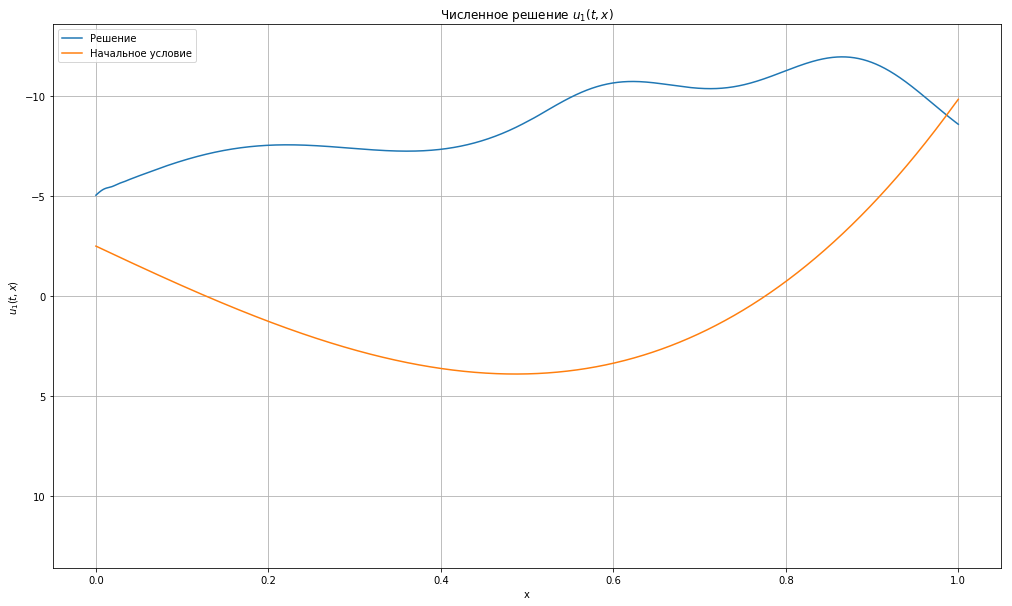

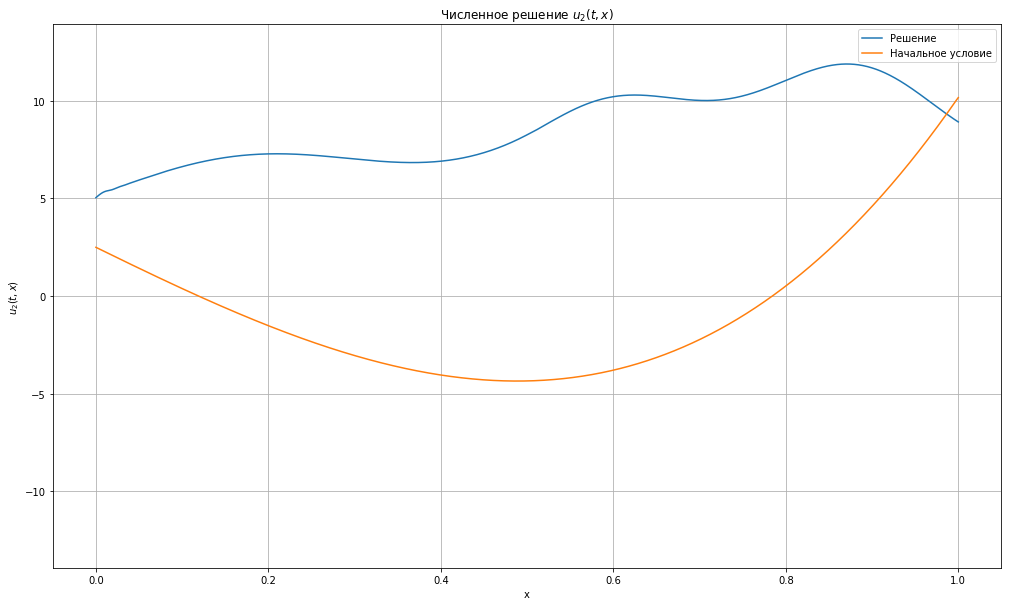

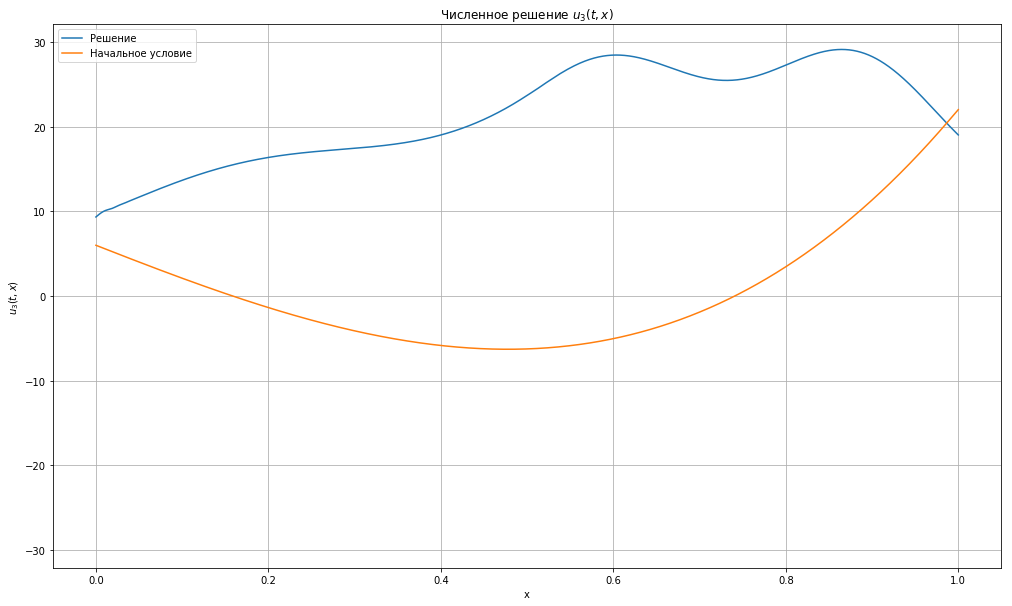

In [36]:
# Анимация первой координаты
anim1 = AnimationHelper(u_1_laks, x_grid=x_grid, t_grid=t_grid, ylabel='u_1')
anim1.make_animation()
anim1.save_as_file('laks_u1.mp4')

# Анимация второй координаты
anim2 = AnimationHelper(u_2_laks, x_grid=x_grid, t_grid=t_grid, ylabel='u_2')
anim2.make_animation().save_as_file('laks_u2.mp4')

# Анимация третьей координаты
anim3 = AnimationHelper(u_3_laks, x_grid=x_grid, t_grid=t_grid, ylabel='u_3')
anim3.make_animation().save_as_file('laks_u3.mp4')

Для наглядности построим график еще 3D график 

C:\Users\aleks\Miniconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


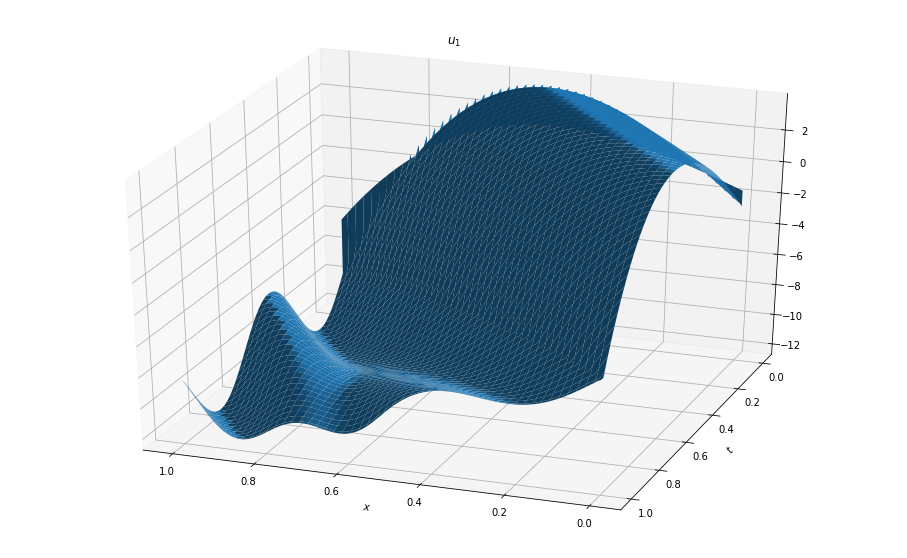

In [37]:
plot_3d(x_grid, t_grid, solution[:,:,0], (30, 110), label='u_1', filename='laks_u1.pdf')

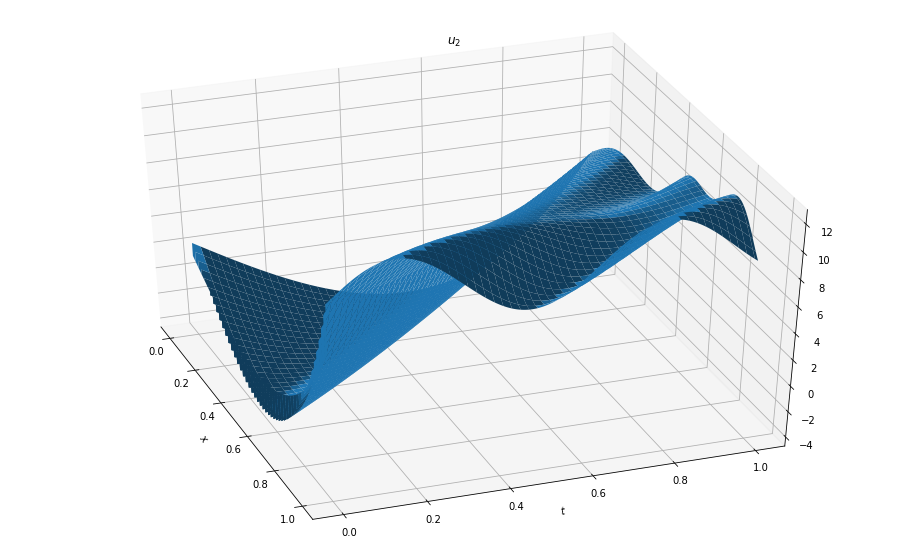

In [38]:
plot_3d(x_grid, t_grid, solution[:,:,1], (40, -20), label='u_2', filename='laks_u2.pdf')

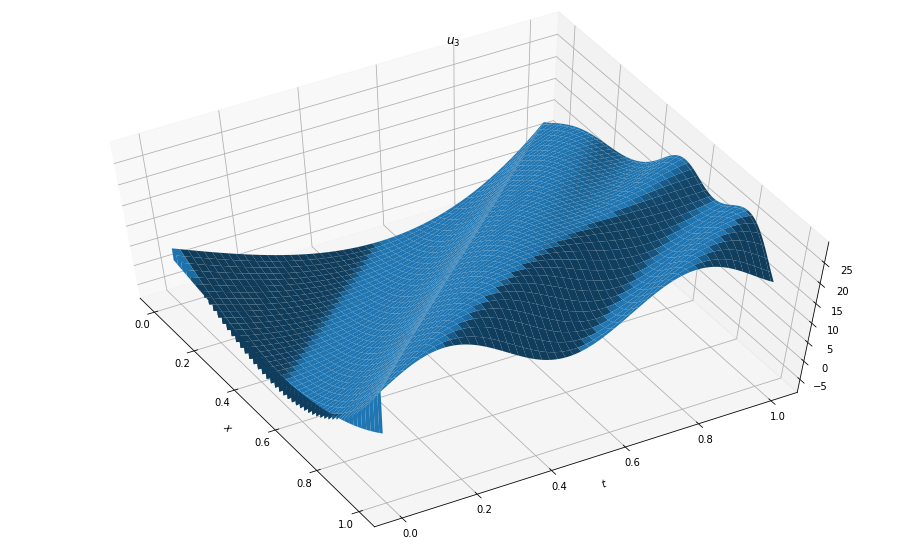

In [39]:
plot_3d(x_grid, t_grid, solution[:,:,2], (60, -30), label='u_3', filename='laks_u3.pdf')

Для определения порядка аппроксимации воспользуемся теми граничными условиями, которые определяют функцию из класса $C^1$. Они были выписаны выше, при теоретическом анализе схемы.

Мы будем считать ошибку по инвариантам Римана (как разность теоретического решения и численного).

In [40]:
timezero_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
# Наглядные синусы
'''
xzero_funcs = [
    lambda t: np.sin(10*t)+timezero_funcs[0](1),
    lambda t: np.sin(10*t)+timezero_funcs[1](1),
    lambda t: np.sin(10*t)+timezero_funcs[2](1)
]
'''
# Не очень наглядно: просто константа
'''
xzero_funcs = [
    lambda t: timezero_funcs[0](1),
    lambda t: timezero_funcs[1](1),
    lambda t: timezero_funcs[2](1),
]
'''
# Продолжение по непрерывности. С ним и будем сравнивать
xzero_funcs = [sp.lambdify(t, x_f) for x_f in x_nepr_border]

tmp = calculate_all(laks_kernel, timezero_funcs, xzero_funcs, 
                    lambdas, h, tau, 
                    x_min=X_MIN, x_max=X_MAX, t_min=T_MIN, t_max=T_MAX)
T, x_grid, t_grid = np.array(tmp[0]), tmp[1], tmp[2]

solution_nepr = T.T

In [41]:
tau = 10**(-2)/2

In [42]:
# Все будем судить по 1-ой координате
N_coord = 0
h_range = np.linspace(10**(-2), 10**(-1), 30)
different_calcs = count_errors(jit(exact_sol_funcs[N_coord]), laks_kernel,
                                       tau, lambdas[N_coord],
                                       h_range,
                                       sigma=0.5)

tau = 0.00250000000000000
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00327586206896552
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00405172413793103
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00482758620689655
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00560344827586207
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00637931034482759
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00715517241379310
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00793103448275862
Created T...
Calculated EXACT...
Calculated inital values...
Calculated approx solution...
tau = 0.00870689655172414
Created T...
Calculated EXACT...
Calcu

In [43]:
errors = np.array([np.linalg.norm(different_calcs[i].astype('float')) for i in range(len(different_calcs))])

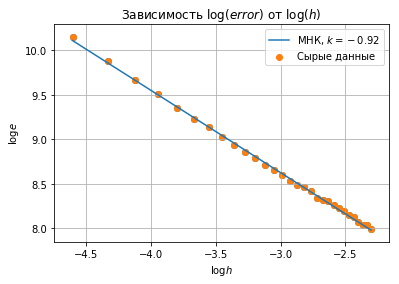

In [44]:
y_plot = np.log(errors)
x_plot = np.log(h_range)

plt.scatter(x_plot, y_plot)
N_forfit=int(len(x_plot)*1)
x_forfit, y_forfit = x_plot[:N_forfit], y_plot[:N_forfit]
plt.scatter(x_forfit, y_forfit, label='Сырые данные')

# Нанесем прямую МНК
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x_forfit, y_forfit)
x_plot_forfit = np.linspace(min(x_forfit), max(x_forfit), 10**3)
y_plot_forfit = slope*x_plot_forfit + intercept
plt.plot(x_plot_forfit, y_plot_forfit, label=r'МНК, $k={}$'.format(slope.round(2)))

plt.grid()
plt.legend()
plt.xlabel(r'$\log h$')
plt.ylabel(r'$\log e$')
plt.title(r'Зависимость $\log(error)$ от $\log(h)$')
plt.savefig('errors_laks.pdf')
plt.show()

In [45]:
display(
    Markdown(
        'Апостериорный порядок сходмиости $k={}$ (коэфф. корреляции $r={}$)'.format(
            abs(slope.round(2)), abs(r_value.round(4))
        )
    )
)

Апостериорный порядок сходмиости $k=0.92$ (коэфф. корреляции $r=0.9994$)